<a href="https://colab.research.google.com/github/kvenkatesh5/AI_monitoring/blob/reproducibility_bjn/statistical_process_control_medimaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CT Statistical Processing Control Charts

The goal of this notebook is to take features calculated and saved in data preparation [OOD_Data_Preparation.ipynb](https://github.com/kvenkatesh5/AI_monitoring/blob/main/notebooks/OOD_Data_Prepration.ipynb) notebook

## Committing notebook changes to Github

`File` --> `Save a copy in Github`

Then make sure you have the correct repository and leave a commit message like shown below:

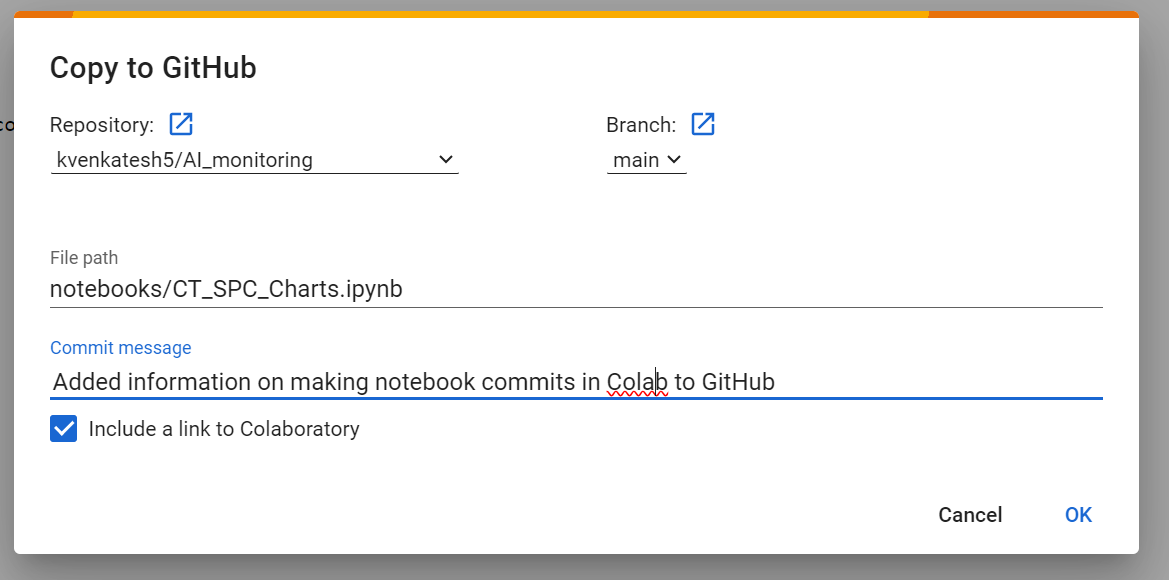

## Download and unpack other source code and install remaining dependencies

In [1]:
!wget -q https://github.com/kvenkatesh5/AI_monitoring/archive/refs/heads/reproducibility_bjn.zip && unzip -q *.zip && rm *.zip && mv AI_monitoring-*/* . && rm -rf AI_monitoring-*/

In [2]:
!pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Generate Features

In [4]:
!if [ ! -d "data" ]; then bash test.sh; fi
# !if [ ! -d "../data" ]; then bash run_all.sh; fi

Model training [1/3] Now running: bash_scripts/autoencoder_runner.sh...
Using downloaded and verified file: data/organamnist.npz
Using downloaded and verified file: data/organcmnist.npz
Using downloaded and verified file: data/organsmnist.npz
Using downloaded and verified file: data/organamnist.npz
Using downloaded and verified file: data/organcmnist.npz
Using downloaded and verified file: data/organsmnist.npz
Using downloaded and verified file: data/organamnist.npz
Using downloaded and verified file: data/organcmnist.npz
Using downloaded and verified file: data/organsmnist.npz
100% 481/481 [00:16<00:00, 29.83it/s]
100% 89/89 [00:02<00:00, 41.85it/s]
==> Saving!
Epoch #1 | Train Loss: 0.1496 | Val Loss: 0.1037 | Best Loss: 0.1037
100% 481/481 [00:14<00:00, 33.12it/s]
100% 89/89 [00:02<00:00, 40.96it/s]
==> Saving!
Epoch #2 | Train Loss: 0.0962 | Val Loss: 0.0975 | Best Loss: 0.0975
==> Model is saved at: saves/conv-autoencoder_lr0.001_bsz128_nep2_indistAxial_time1700691078.808032.pt !


In [9]:
!bash test.sh

Generating features
Device: cuda | # 1
Using downloaded and verified file: data/organamnist.npz
Using downloaded and verified file: data/organcmnist.npz
Using downloaded and verified file: data/organsmnist.npz
Using downloaded and verified file: data/organamnist.npz
Using downloaded and verified file: data/organcmnist.npz
Using downloaded and verified file: data/organsmnist.npz
Using downloaded and verified file: data/organamnist.npz
Using downloaded and verified file: data/organcmnist.npz
Using downloaded and verified file: data/organsmnist.npz
100% 61521/61521 [00:12<00:00, 4960.09it/s]
100% 11335/11335 [00:02<00:00, 5533.45it/s]
100% 34875/34875 [00:07<00:00, 4511.03it/s]
Loading! <= saves/conv-autoencoder_lr0.001_bsz128_nep2_indistAxial_time1700691078.808032.pt
==> Loading!
100% 1923/1923 [00:13<00:00, 141.44it/s]
100% 1090/1090 [00:07<00:00, 149.46it/s]
Saved Autoencoder features for model: conv-autoencoder_lr0.001_bsz128_nep2_indistAxial_time1700691078.808032.pt
Loading! <= saves

## Plot SPC Charts

In [10]:
"""SPC charts (three-sigma, CUSUM), code adapted from Ghada"""
import pandas as pd
import numpy as np
import random
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.linalg import pinv
from PIL import Image
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
import numpy as np
import os
from numpy.linalg import pinv
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
sns.set_style('darkgrid')
np.random.seed(2021)
random.seed(2021)

from matplotlib.ticker import StrMethodFormatter
import os
import warnings
warnings.filterwarnings("ignore")

In [12]:
"""Load dataset"""
D = np.load("data/numpy_files/data_splits.npz")
Xtr = D["Xtr"]
ytr = D["ytr"]
Xvl = D["Xvl"]
yvl = D["yvl"]
Xtt = D["Xtt"]
ytt = D["ytt"]

In [14]:
"""Load contrastive features"""
model_type = 'cnn'
F = np.load(f'data/numpy_files/{model_type}_features.npz')
Ftr = F[f"{model_type}_Ftr"]
Ftt = F[f"{model_type}_Ftt"]
# Get features for all in-distribution (ID) training images
train_features = Ftr[ytr == 1]
in_dist_test_features = Ftt[ytt == 1]
out_dist_test_features = Ftt[ytt == 0]
assert np.shape(in_dist_test_features)[0] + np.shape(out_dist_test_features)[0] == ytt.shape[0]

In [15]:
"""Compute cosine similarities"""
# Function to compute cosine similarity
def compute_cosine_similarity(tr_features_, tt_features_):
    centroid = np.mean(tr_features_, axis=0)
    similarities = [1 - distance.cosine(feature, centroid) for feature in tt_features_]
    return similarities

cosine_train_similarities = compute_cosine_similarity(train_features, train_features)
cosine_mean_train = np.mean(cosine_train_similarities)
cosine_std_train = np.std(cosine_train_similarities)

# Print statistics
print("MEAN train: {} | STD train: {}".format(cosine_mean_train, cosine_std_train))

# 2 and 3 sigma control limits
cosine_2UCL_train_upper = cosine_mean_train + 2 * cosine_std_train
cosine_2LCL_train_lower = cosine_mean_train - 2 * cosine_std_train
cosine_3UCL_train_upper = cosine_mean_train + 3 * cosine_std_train
cosine_3LCL_train_lower = cosine_mean_train - 3 * cosine_std_train

# Median and Median Absolute Deviation (MAD) for in-control
median_train = np.median(cosine_train_similarities)
mad_train = np.median(np.abs(cosine_train_similarities - median_train))

# Percentiles (e.g., 95th and 99th percentiles) for in-control
percentile_95_train = np.percentile(cosine_train_similarities, 95)
percentile_99_train = np.percentile(cosine_train_similarities, 99)

# Range (R) and Interquartile Range (IQR) for in-control
range_train = np.ptp(cosine_train_similarities)
iqr_train = np.percentile(cosine_train_similarities, 75) - np.percentile(cosine_train_similarities, 25)

# Compute cosine similarity statistics for in-control or in-distribution test features
cosine_in_dist_similarities = compute_cosine_similarity(train_features, in_dist_test_features)
cosine_mean_in_dist = np.mean(cosine_in_dist_similarities)
cosine_std_in_dist = np.std(cosine_in_dist_similarities)
print("MEAN in_dist_test: {} | STD in_dist_test: {}".format(cosine_mean_in_dist, cosine_std_in_dist))

# Compute cosine similarity statistics for out-of-distribution test features
cosine_out_dist_similarities = compute_cosine_similarity(train_features, out_dist_test_features)
cosine_mean_out_dist = np.mean(cosine_out_dist_similarities)
cosine_std_out_dist = np.std(cosine_out_dist_similarities)
print("MEAN out_dist_test: {} | STD out_dist_test: {}".format(cosine_mean_out_dist, cosine_std_out_dist))

MEAN train: 0.7105961647831057 | STD train: 0.10395763633266507
MEAN in_dist_test: 0.631702426767769 | STD in_dist_test: 0.1846873035933458
MEAN out_dist_test: 0.16267704532999822 | STD out_dist_test: 0.11686073520692923


In [16]:
"""Time simulation
Days 0-20: 0.5% error rate
Days 20-60: 0.5-2% error rate (uniformly random)
Days 60-100: 2-5% error rate (uniformly random)
"""
# Define the number of days and images per day
total_days = 100
images_per_day = 500

# Create an empty list to store daily data
all_data = []
percentages_out_dist = []

# Function to select data for each day
def select_daily_data(in_dist_data, out_dist_data, out_dist_percent, day_data_count):
    out_dist_count = int(day_data_count * out_dist_percent / 100)
    in_dist_count = day_data_count - out_dist_count

    # Randomly select out-of-distribution and in-distribution data
    daily_out_dist_data = np.random.choice(out_dist_data, out_dist_count, replace=False)
    daily_in_dist_data = np.random.choice(in_dist_data, in_dist_count, replace=False)

    # Combine and return the daily data
    return np.concatenate([daily_out_dist_data, daily_in_dist_data])

 # Simulate data for each day
for day in range(1, total_days + 1):
    if day <= 20:
        percent_out_dist = 0.5
    elif day <= 60:
        percent_out_dist = (0.5, 2)
    elif day <= 100:
        percent_out_dist = (2, 5)

    # If range is given for percent, choose randomly
    if type(percent_out_dist) == tuple:
        p = np.random.uniform(low=percent_out_dist[0], high=percent_out_dist[1])
    else:
        p = percent_out_dist
    percentages_out_dist.append(p)

    daily_data = select_daily_data(
        cosine_in_dist_similarities,
        cosine_out_dist_similarities,
        p,
        images_per_day
    )
    all_data.append(daily_data)


# Combine all daily data for CUSUM analysis
avg_cusum_data = np.concatenate(all_data)
daily_averages = [np.mean(day) for day in all_data]
CUSUM_data_average_day = np.array(daily_averages)

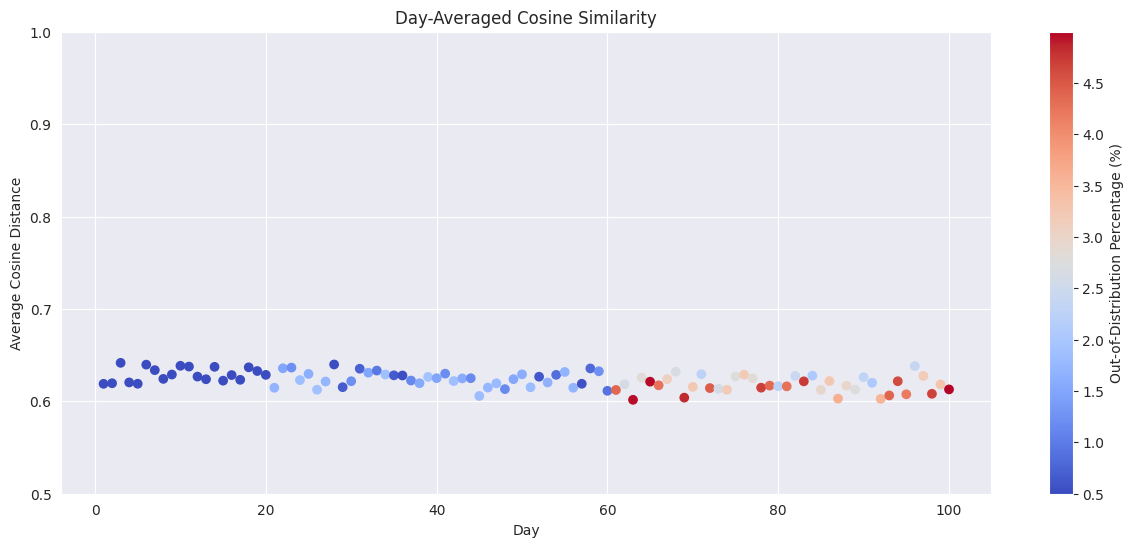

In [17]:
"""Plotting day-averaged cosine distance"""
plt.figure(figsize=(15, 6))
sc = plt.scatter(range(1, total_days + 1), daily_averages, c=percentages_out_dist, cmap='coolwarm')
plt.colorbar(sc, label='Out-of-Distribution Percentage (%)')
plt.title('Day-Averaged Cosine Similarity')
plt.xlabel('Day')
plt.ylabel('Average Cosine Distance')
plt.ylim([0.5, 1])
plt.grid(True)
plt.show()

In [30]:
# Save the cosine similarity for each batch for each day.
np.savetxt("data/numpy_files/per_day_cosine_CUSUM.csv", daily_averages, delimiter=",", fmt='%s')

In [31]:
"""Plot 3-sigma chart for a single day"""
sample_days = [10, 40, 80]
day_data = {}
day_labels = {}
for i, day in enumerate(sample_days):
    index = day-1
    percentage_out_dist = percentages_out_dist[index]
    out_dist_count = int(images_per_day * percentage_out_dist / 100)
    in_dist_count = images_per_day - out_dist_count
    labels = ['out-dist'] * out_dist_count + ['in-dist'] * in_dist_count
    data = all_data[index]
    combined = list(zip(data, labels))
    np.random.shuffle(combined)
    shuffled_data, shuffled_labels = zip(*combined)
    day_data[i+1] = list(shuffled_data)
    day_labels[i+1] = list(shuffled_labels)

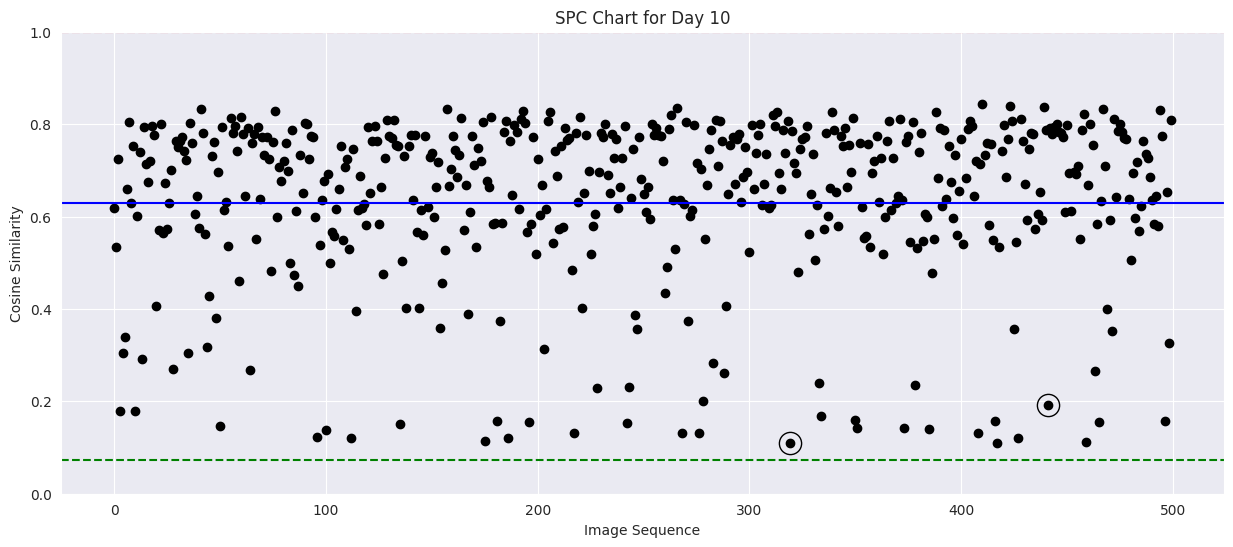

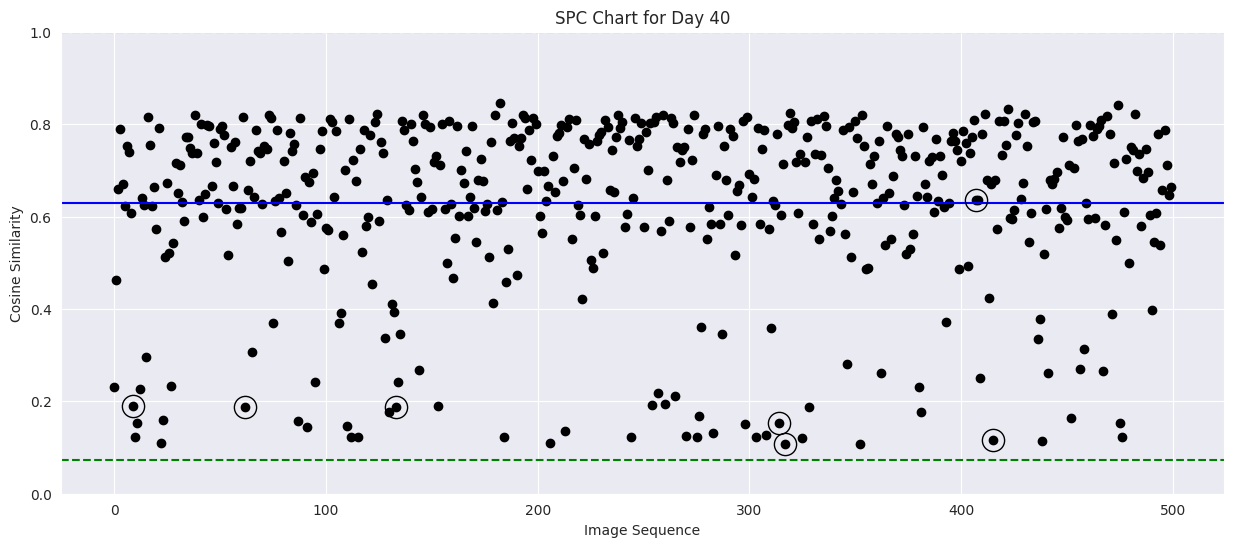

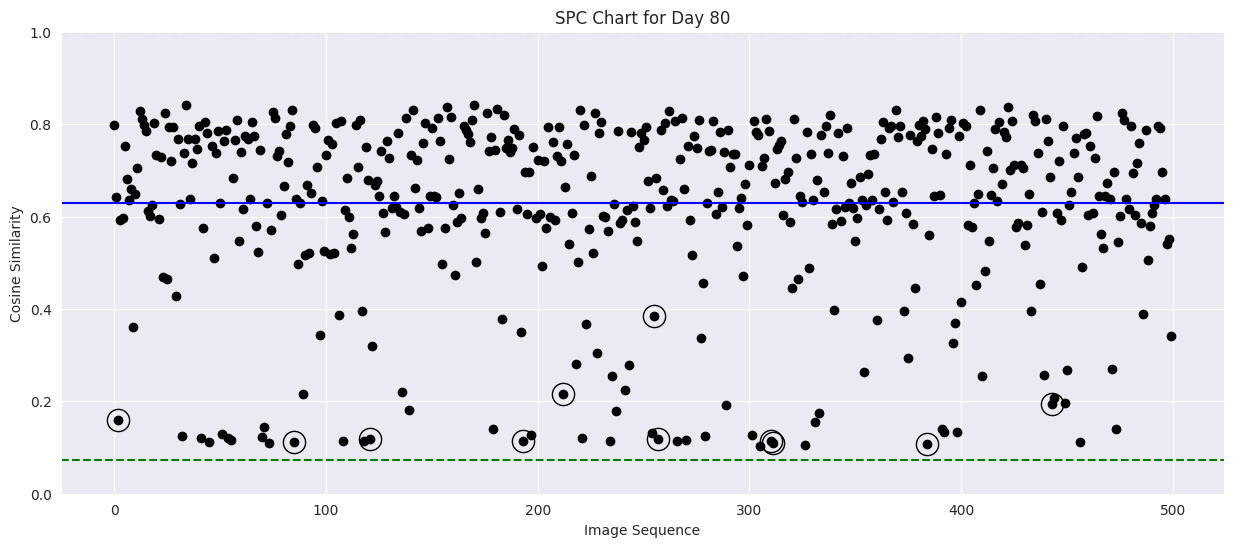

In [20]:
# Per-image control limits based on individual images collected pre-shift
pre_shift_data = all_data[:20]
mean_pre_shift = np.mean(pre_shift_data)
std_pre_shift = np.std(pre_shift_data)
upper_control_limit = np.clip(mean_pre_shift + 3 * std_pre_shift, a_min=0.0, a_max=1.0)
lower_control_limit = np.clip(mean_pre_shift - 3 * std_pre_shift, a_min=0.0, a_max=1.0)

# Let's create a function to plot SPC chart for given day, using train control limits
def plot_spc_chart(day_data, day_labels, day_number):
    # Plot the SPC chart
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.scatter(list(range(images_per_day)), day_data, marker='o', linestyle='-', color='k', label=f' {day_number} Data')  # Black color for plot

    # Plot control limits and mean
    ax.axhline(upper_control_limit, color='r', linestyle='--', label='Upper Control Limit (UCL)')  # Red color for UCL
    ax.axhline(lower_control_limit, color='g', linestyle='--', label='Lower Control Limit (LCL)')  # Green color for LCL
    ax.axhline(mean_pre_shift, color='b', linestyle='-', label='Mean')  # Blue color for mean

    # Highlight out-of-distribution points and draw a circle around them as known ground truth
    for i, (val, label) in enumerate(zip(day_data, day_labels)):
        if np.abs(val - mean_pre_shift) >= 3*std_pre_shift:
            ax.plot(i, val, '*', color='grey', markersize=16, label='Auto OOD')
        if label == 'out-dist':
            # ax.scatter(i, val, color='red', marker='o', s=50)  # Red circles for known out-of-control points
            # ax.scatter(i, val, facecolors='none', edgecolors='blue', marker='o', s=200)  # Blue circle around the point
            ax.plot(i, val, marker='o', markersize=16, linestyle='None', color='black', mfc='none', label='Actual OOD')

    ax.set_title(f'SPC Chart for {day_number}')
    ax.set_xlabel('Image Sequence')
    ax.set_ylabel('Cosine Similarity')
    ax.set_ylim([0, 1])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys())
    ax.grid(True)

    plt.show()


# Now we plot the SPC charts
for day, day_number in enumerate(sample_days, start=1):
  day_title = f'Day {day_number}'  # Create a title string for the chart
  plot_spc_chart(day_data[day], day_labels[day], day_title)

In [21]:
# Function to create the first vector
def create_control_vector(samples, upper_limit, lower_limit):
    return [1 if val > upper_limit or val < lower_limit else 0 for val in samples]

# Function to create the second vector
def create_shift_vector(length, shift_start):
    return [0 if i < shift_start else 1 for i in range(length)]

0.6296710695161631
0.6211622551035136


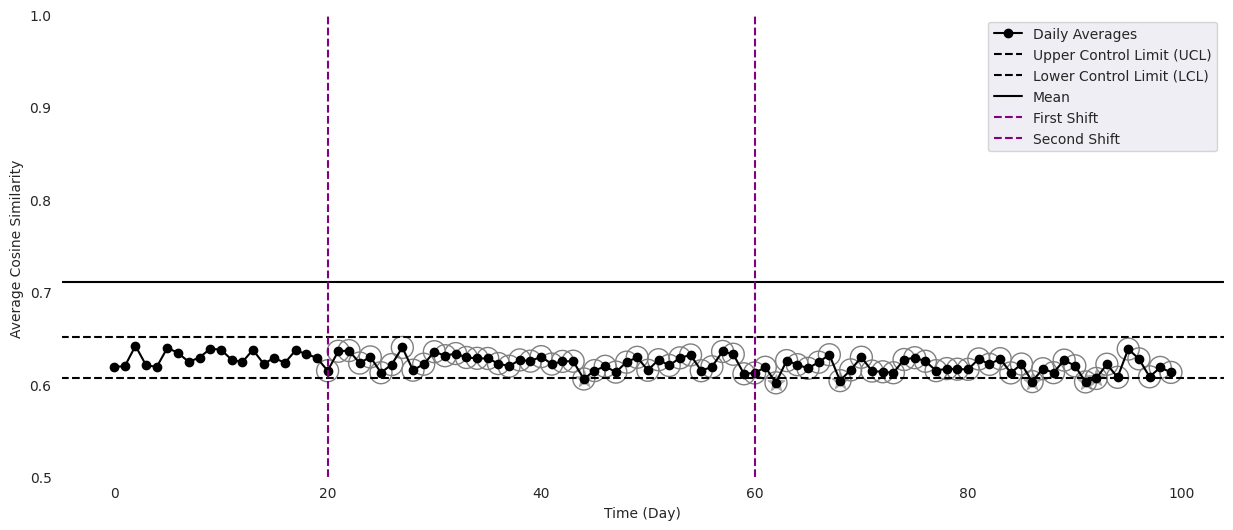

In [22]:
"""Three-sigma SPC chart for per-day averages"""
# Define the control limits using the three-sigma rule
upper_control_limit = np.mean(daily_averages[:20]) + 3 * np.std(daily_averages[:20])
lower_control_limit = np.mean(daily_averages[:20]) - 3 * np.std(daily_averages[:20])

print(np.mean(daily_averages[1:20]))
print(np.mean(daily_averages[20:100]))

shift_start_day = 20

# Create Bernoulli CUSUM vectors
average_binary_3sigma_vector = create_control_vector(daily_averages, upper_control_limit, lower_control_limit)
average_ground_truth_vector = create_shift_vector(len(daily_averages), shift_start_day)

# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(daily_averages, marker='o', linestyle='-', color='k', label='Daily Averages')  # Black color for plot

# Plot control limits and mean
ax.axhline(upper_control_limit, color='k', linestyle='--', label='Upper Control Limit (UCL)')  # Black color for UCL
ax.axhline(lower_control_limit, color='k', linestyle='--', label='Lower Control Limit (LCL)')  # Black color for LCL
ax.axhline(cosine_mean_train, color='k', linestyle='-', label='Mean')  # Black color for mean

# Highlight points outside of control limits with grey circle around them
for i, val in enumerate(daily_averages):
    if val > upper_control_limit or val < lower_control_limit:
        ax.scatter(i, val, color='darkgrey', marker='*', s=150)  # Dark grey stars for out-of-control points
        #ax.scatter(i, val, facecolors='none', edgecolors='grey', marker='o', s=250)  # Grey circle around out-of-control points

# Circle all points after the shift point
for i in range(20, len(daily_averages)):
    ax.scatter(i, daily_averages[i], facecolors='none', edgecolors='grey', marker='o', s=250)  # Grey circle around points after shift
# Indicate the first shift point
ax.axvline(x=20, color='purple', linestyle='--', label='First Shift')  # Purple line for shift start
# Indicate the second shift point
ax.axvline(x=60, color='purple', linestyle='--', label='Second Shift')  # Purple line for shift start

ax.set_facecolor('white')  # White background
ax.set_xlabel('Time (Day)')
ax.set_ylabel('Average Cosine Similarity ')
ax.set_ylim([0.5,1])
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Lighter grid lines for better visibility

# Show the plot
plt.show()

In [23]:
"""Bernoulli CUSUM function"""
def bernoulli_cusum(data, p, k, h):
    """Compute the Bernoulli CUSUM for given binary data.

    :param data: Array of binary outcomes (based on three-sigma rule)
    :param p: Expected probability of success
    :param k: Reference value (allowance)
    :param h: Decision interval (threshold)
    :return: Tuple of (C_plus, C_minus, signals)
    """
    C_plus = [0]
    C_minus = [0]

    for i in range(len(data)):
        C_plus.append(max(0, C_plus[-1] + (data[i] - p - k)))
        C_minus.append(max(0, C_minus[-1] - (data[i] - p + k)))

    C_plus = np.array(C_plus[1:])
    C_minus = -np.array(C_minus[1:])  # Make negative for visualization

    signal_plus = np.where(C_plus > h)[0]
    signal_minus = np.where(C_minus < -h)[0]
    signals = np.unique(np.concatenate((signal_plus, signal_minus)))

    return C_plus, C_minus, signals

In [24]:
"""Bernoulli CUSUM Parameters"""
n = len(average_binary_3sigma_vector)
p_initial = 0.01
p_shift = 0.05
shift_point = 20
# thresholds = [1, 2, 3, 4, 5]
thresholds = [4]
p_expected = p_initial
k = 0.5 * (p_shift - p_initial)

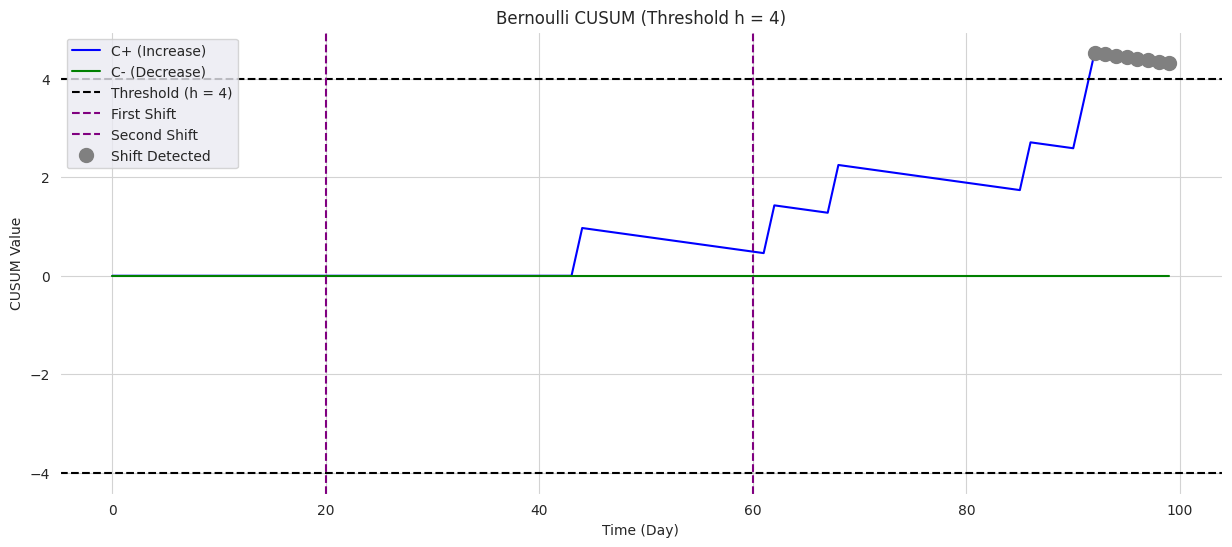

   Threshold  Detection Time  False Alarms  False Alarm Rate  Missed Detections
0          4              72             0               0.0                 72


In [25]:
# Known shift point and total number of days
shift_point = 20  # The shift occurs on day 30
total_days = 100   # Total number of days

# Metrics table
metrics = []

# Iterate over thresholds
for h in thresholds:
    # Compute CUSUM for actual observations using the control vector
    C_plus, C_minus, signals = bernoulli_cusum(average_binary_3sigma_vector, p_expected, k, h)

    # Calculate the performance metrics based on the known shift point
    detected_shifts = [signal for signal in signals if signal > shift_point]
    false_alarms = len([signal for signal in signals if signal <= shift_point])

    # Calculate missed detections
    # All days after the shift point that were not detected are considered missed
    missed_detections = total_days - shift_point - len(detected_shifts)

    # Calculate detection time for the first detected shift after the shift point
    detection_time = detected_shifts[0] - shift_point if detected_shifts else None

    # Calculate false alarm rate
    false_alarm_rate = false_alarms / shift_point

    # Append the metrics for this threshold to the metrics list
    metrics.append({
        'Threshold': h,
        'Detection Time': detection_time,
        'False Alarms': false_alarms,
        'False Alarm Rate': false_alarm_rate,
        'Missed Detections': missed_detections
    })

    # Plotting the CUSUM statistics for actual data
    fig, ax = plt.subplots(figsize=(15, 6))

    plt.plot(C_plus, label='C+ (Increase)', color='blue')
    plt.plot(C_minus, label='C- (Decrease)', color='green')
    plt.axhline(y=h, color='black', linestyle='--', label=f'Threshold (h = {h})')
    plt.axhline(y=-h, color='black', linestyle='--')
    #plt.axvline(x=shift_point, color='purple', linestyle='--', label='Shift Point')


    # Indicate the first shift point
    ax.axvline(x=20, color='purple', linestyle='--', label='First Shift')  # Purple line for shift start
    # Indicate the second shift point
    ax.axvline(x=60, color='purple', linestyle='--', label='Second Shift')  # Purple line for shift start

    for signal in signals:
        plt.plot(signal, C_plus[signal] if C_plus[signal] > 0 else C_minus[signal],
                 'o', color='grey', markersize=10, label='Shift Detected' if signal == signals[0] else "")
       # plt.plot(signal, C_minus[signal] if C_minus[signal] > 0 else C_minus[signal],
       #          'o', color='grey', markersize=10, label='Shift Detected' if signal == signals[0] else "")


    ax.set_facecolor('white')  # White background
    plt.title(f'Bernoulli CUSUM (Threshold h = {h})')
    plt.xlabel('Time (Day)')
    plt.ylabel('CUSUM Value')
    plt.legend()
    ax.grid(True, color='lightgrey')  # Black grid lines
    plt.show()


# Convert the metrics list to a DataFrame for a nice tabular display
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

In [26]:
"""CUSUM function"""
def CUSUM(x, mu0, k, h):
    S_hi = [0]
    S_lo = [0]
    for i in range(len(x)):
        S_hi.append(max(0, S_hi[i] + (x[i] - mu0 - k)))
        S_lo.append(min(0, S_lo[i] + (x[i] - mu0 + k)))

    S_hi = np.array(S_hi[1:])
    S_lo = np.array(S_lo[1:])

    signal_hi = np.where(S_hi > h)[0]
    signal_lo = np.where(S_lo < -h)[0]
    signal = np.unique(np.concatenate((signal_hi, signal_lo)))

    return signal, S_hi, S_lo

In [27]:
# Define the range of k values as a fraction of in_std
# k_values = [0.1, 0.25, 0.5, 0.75, 1.0]
k_values = [0.1, 0.25, 0.5]
# Specify the control parameters and the threshold
pre_change_days = 20  # Number of days the process is in-control
total_days = 100  # Total number of days in the dataset
control_limit = 4  # Multiplier for control limit
delta = 1  # Change magnitude in terms of standard deviations

# Split your data into in-control and out-of-control periods
in_control_sp = CUSUM_data_average_day[:pre_change_days]
out_control_sp = CUSUM_data_average_day[pre_change_days:total_days]

# Compute the mean and standard deviation for in-control and out-of-control periods
mu_in = np.mean(in_control_sp)
mu_out = np.mean(out_control_sp)
in_std = np.std(in_control_sp)

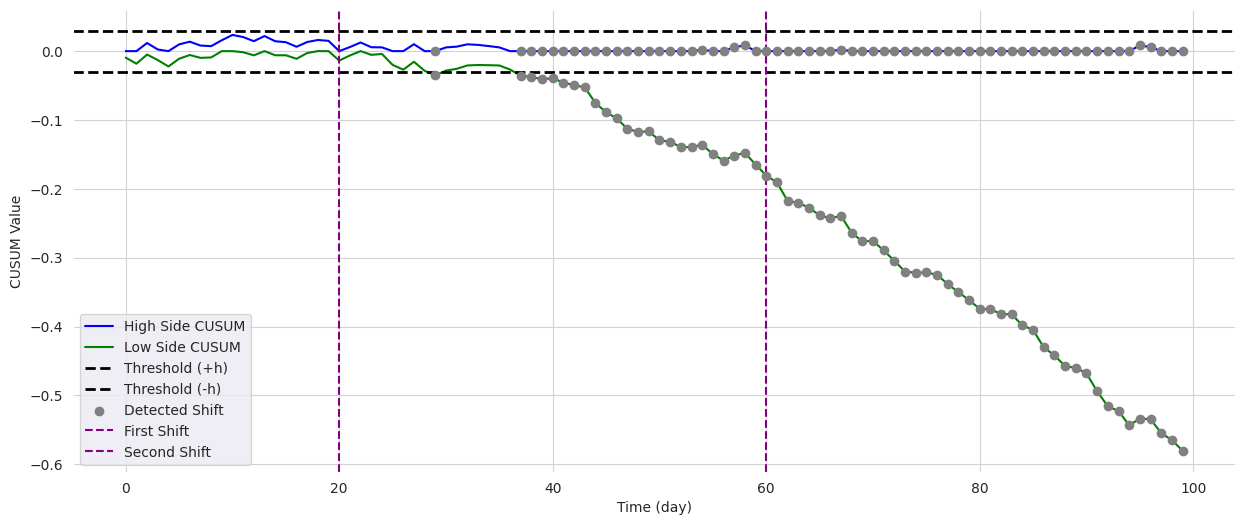

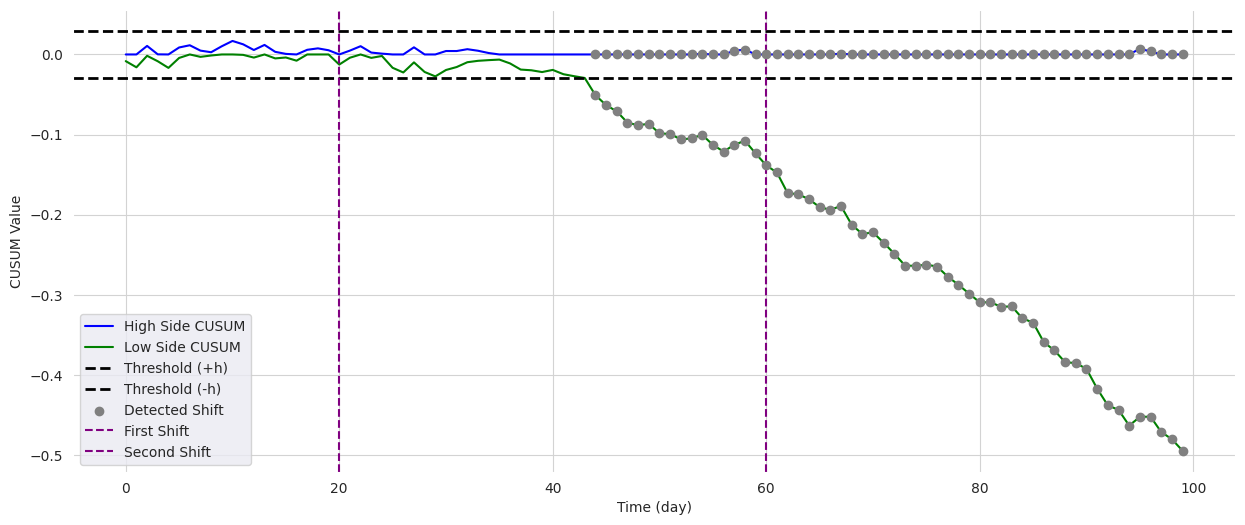

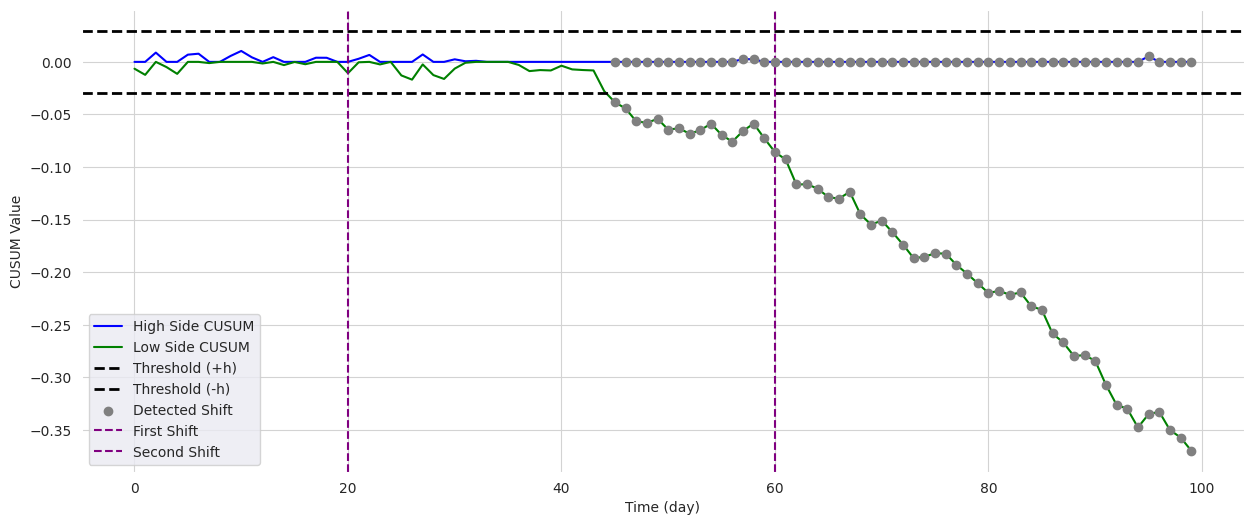

In [28]:
for k_th in k_values:
    k = k_th * in_std
    h = control_limit * in_std  # h equal to 4*std

    # Initialize lists to store results
    FalsePos = []
    TruePos = []
    AvgDD = []  # Average Detection Delay
    DetectionTimes = []

    # Call the CUSUM function
    signal, S_hi, S_lo = CUSUM(CUSUM_data_average_day, mu_in, k, h)
    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))

    ax.plot(S_hi, label='High Side CUSUM', color='blue')
    ax.plot(S_lo, label='Low Side CUSUM', color='green')
    ax.axhline(y=h, color='black', linestyle='--', linewidth=2, label='Threshold (+h)')
    ax.axhline(y=-h, color='black', linestyle='--', linewidth=2, label='Threshold (-h)')
    ax.scatter(signal, [S_hi[i] for i in signal], color='grey', zorder=5, label='Detected Shift')
    ax.scatter(signal, [S_lo[i] for i in signal], color='grey', zorder=5)

    # Indicate the first shift point
    ax.axvline(x=20, color='purple', linestyle='--', label='First Shift')  # Purple line for shift start
    # Indicate the second shift point
    ax.axvline(x=60, color='purple', linestyle='--', label='Second Shift')  # Purple line for shift start

    #ax.set_title(f'Processing for k = {k}')
    ax.set_facecolor('white')  # White background

    ax.set_xlabel('Time (day)')
    ax.set_ylabel('CUSUM Value')
    ax.legend()
    ax.grid(True, color='lightgrey')  # Black grid lines
    plt.show()

     # Calculate False Positives
    for i in range(pre_change_days):
        if S_hi[i] > h or S_lo[i] > -h:  # Assuming symmetry around zero for S_lo
            FalsePos.append(i + 1)
            DetectionTimes.append(i + 1)

    # Calculate True Positives and Detection Delay
    for i in range(pre_change_days, total_days):
        if S_hi[i] > h or S_lo[i] > -h:
            TruePos.append(i + 1)
            AvgDD.append(i + 1 - pre_change_days)
            break  # Remove this break if you want to count all true positives

In [29]:
# Initialize summary_metrics list here
summary_metrics = []

for k_th in k_values:
    FalsePos = []
    TruePos = []
    AvgDD = []
    DetectionTimes = []
    DetectionDelays = []


    k = k_th * in_std
    h = control_limit * in_std

    signal, S_hi, S_lo = CUSUM(CUSUM_data_average_day, mu_in, k, h)


    # Calculate False Positives, True Positives, and Detection Delay
    for i in range(pre_change_days):
        if S_hi[i] > h or S_lo[i] < -h:
            FalsePos.append(i)


    for i in range(shift_point, total_days):
        if S_hi[i] > h or S_lo[i] < -h:
            TruePos.append(i)  # Append the index of true detection
            DetectionDelays.append(i - shift_point)  # Calculate the delay for this detection

    # Calculate ADD only if there are true positives detected
    if TruePos:
      ADD = np.mean(DetectionDelays)
    else:
      ADD = None  # No true positives detected


    AvgDD = []  # Re-initialize for each threshold

    # Calculate True Positives and Detection Delay
    for i in range(shift_point, total_days):  # Start from the actual shift point
      if S_hi[i] > h or S_lo[i] < -h:
          detection_delay = i - shift_point
          AvgDD.append(detection_delay)
          break  # Break after the first detection

      # Now calculate the average detection delay
    average_detection_delay = np.mean(AvgDD) if AvgDD else None

    # Calculate MTBFA and FAR
    MTBFA = pre_change_days / len(FalsePos) if FalsePos else float('inf')
    FalseAlarmRate = len(FalsePos) / pre_change_days if FalsePos else 0

    summary_metrics.append({
        "Threshold": k_th,
        "False Positives": len(FalsePos),
        "True Positives": len(TruePos),
        "Average Detection Delay": np.mean(AvgDD) if AvgDD else None,
        "MTBFA": MTBFA,
        "False Alarm Rate": FalseAlarmRate
    })

# Create the summary DataFrame outside the loop
summary_df = pd.DataFrame(summary_metrics)

# Print the summary table
print(summary_df.to_string(index=False))

 Threshold  False Positives  True Positives  Average Detection Delay  MTBFA  False Alarm Rate
      0.10                0              64                      9.0    inf                 0
      0.25                0              56                     24.0    inf                 0
      0.50                0              55                     25.0    inf                 0
